In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

## Funciones generales

In [3]:
#Da el espectro identificando los primeros máximos sin analizar
def Spectrum(datax,datay,intensity,num):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>intensity):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-num:i+num] )
                index_x.append( datax[i-num:i+num] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones


#Procesa el archivo txt de datos, inten se refiere a la intensidad mínima para buscar y num a la cantidad de puntos alrededor de la lorentziana
def DataProcess(l,inten,num):
    data = pd.read_csv(l, delimiter=' ')
    pixel = np.array(data['P'])
    intensidad = np.array(data['I'])

    marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad,inten,num)
    
    return pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones


#Retira aquellas líneas que no aparecen en el catálogo o no ayudan a la obtención de la lorentziana
def DataCatalogue(pixs,marker_x,marker_y, index_x,index_y,anotaciones):
    mar_x = []
    mar_y = []
    ind_y = []
    ind_x = []
    anot = []
   

    for i in range(0,len(marker_x)):
        if marker_x[i] not in pixs:
            mar_x.append(marker_x[i])
            mar_y.append(marker_y[i])
            ind_x.append(index_x[i])
            ind_y.append(index_y[i])
            anot.append(anotaciones[i])

    return mar_x,mar_y, ind_x,ind_y,anot


#Función Lorentziana
def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)


#Realiza el ajuste Lorentziano sobre el espectro catalogado
def AjusteLorentz(i,index_x, index_y):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y


#Devuelve el DataFrame con los píxeles calculados
def MakeDataFrame(rango,catalog_long,index_x, index_y):

    Datafit = pd.DataFrame()
    lineasfit = []
    alturafit = []

    for i in range(0,rango):
        linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x, index_y)
        lineasfit.append(linea)
        alturafit.append(altura)
    

    Datafit['Pixel'] = lineasfit
    Datafit['Intensidad'] = alturafit
    Datafit['Catalogo longitud'] = catalog_long

    return Datafit

#Obtener la regresion lineal
def LinearFit(datax,datay,n):
    param = np.polyfit(datax,datay, n)
    xm = np.linspace(min(datax),max(datax),len(datax))
    ym = np.polyval(param, xm)
    xres = datax
    ye = np.polyval(param, datax)
    res = ye - datay

    return ym,xm,res,xres,param

#Obtener la calibración de las lineas sospechosas
def LineasSus(pixs,param):
    Data = pd.DataFrame()
    Data['Pixel'] = pixs
    Orden1 = []
    Orden2 = []
    Orden3 = []
    for i in pixs:
        Orden1.append(np.polyval(param,i)*2)
        Orden2.append(np.polyval(param,i)) 
        Orden3.append(np.polyval(param,i)*(2/3)) 
    
    Data['Calibracion orden 1'] = Orden1
    Data['Calibracion orden 2'] = Orden2
    Data['Calibracion orden 3'] = Orden3

    return Data

#Convertir DataFrame a tabla de Latex
# print(DataFit_1.to_latex(index=False))

# Linea para guardar la imagen de un fig
#fig2.savefig('th 6200 orden 2 espectro tratado.jpg')

## Análisis

### Para intensidades grandes >1805

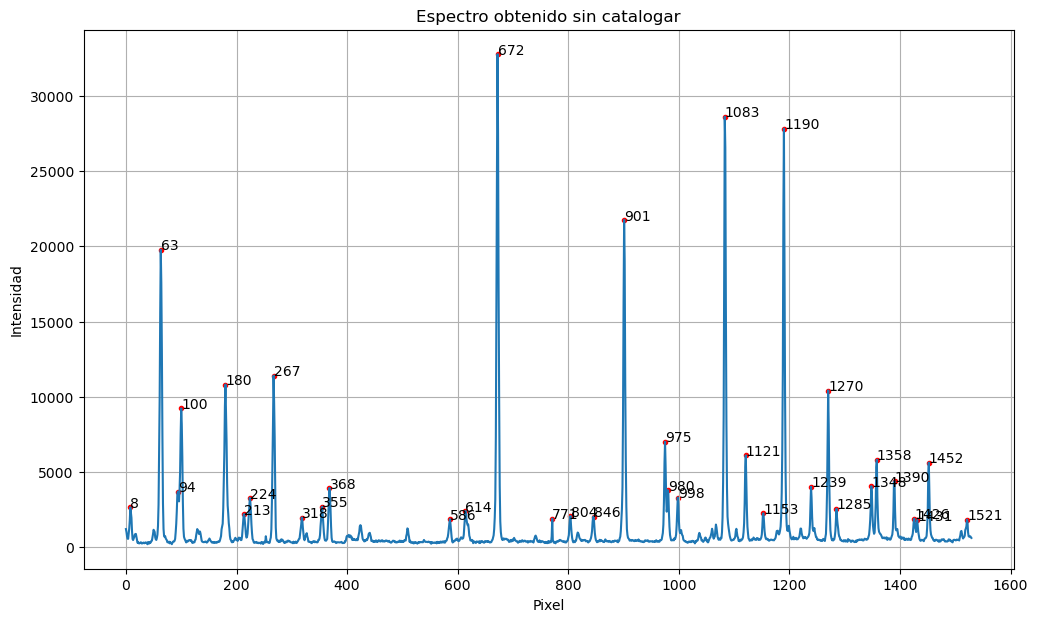

In [4]:
pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6480\th 6480 orden 2 spec.txt", 1805, 7)

#Grafica para ver el espectro completo y cuadrar hasta qué intensidad mirar
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Espectro obtenido sin catalogar')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))

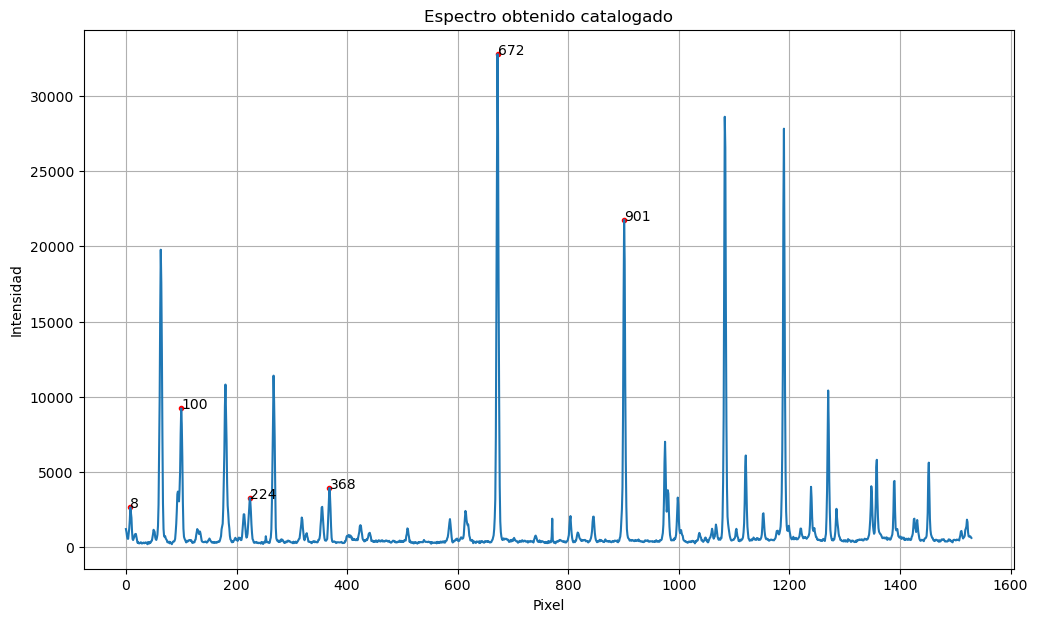

In [5]:
#Lista de pixeles que se descartan al no estar en el espectro
Pixnon_1 = [ 63, 94, 180, 213, 267, 318, 355, 586, 614, 771,804, 846, 975, 980, 998, 1083, 1121, 1153, 1190, 1239, 1270, 1285, 1348, 1358, 1390, 1426,1431, 1452, 1521]

#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl,marker_yl, index_xl,index_yl,anotacionesl = DataCatalogue(Pixnon_1,marker_x,marker_y, index_x,index_y,anotaciones)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl,marker_yl,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl):
    plt.annotate(label, (marker_xl[i] + 0.1, marker_yl[i]))


In [6]:
#Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
catalog_long_1 = [6441.950, 6443.890, 6446.771, 6450.006, 6457.282 ,6462.595]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_1 = [804, 846, 1153, 1270, 1431]

#Lista de líneas completamente sospechosas 
Pixsus_1 = [ 63, 180, 213, 267, 318, 355, 586, 614, 771, 975, 998, 1083, 1121,  1190, 1239, 1285, 1348, 1358, 1390, 1452, 1521]

#Unir dataframes de líneas en el catalogo
DataFit_1 = MakeDataFrame(len(marker_xl),catalog_long_1,index_xl, index_yl)
DataFit_1

,Pixel,Intensidad,Catalogo longitud
0,8.340459,2531.915059,6441.950
1,99.861025,8918.631036,6443.890
2,224.187629,3280.945769,6446.771
3,368.192870,4025.838344,6450.006
4,672.101623,34053.864569,6457.282
5,901.182300,23004.694468,6462.595


### Para líneas con intensidades pequeñas < 1805

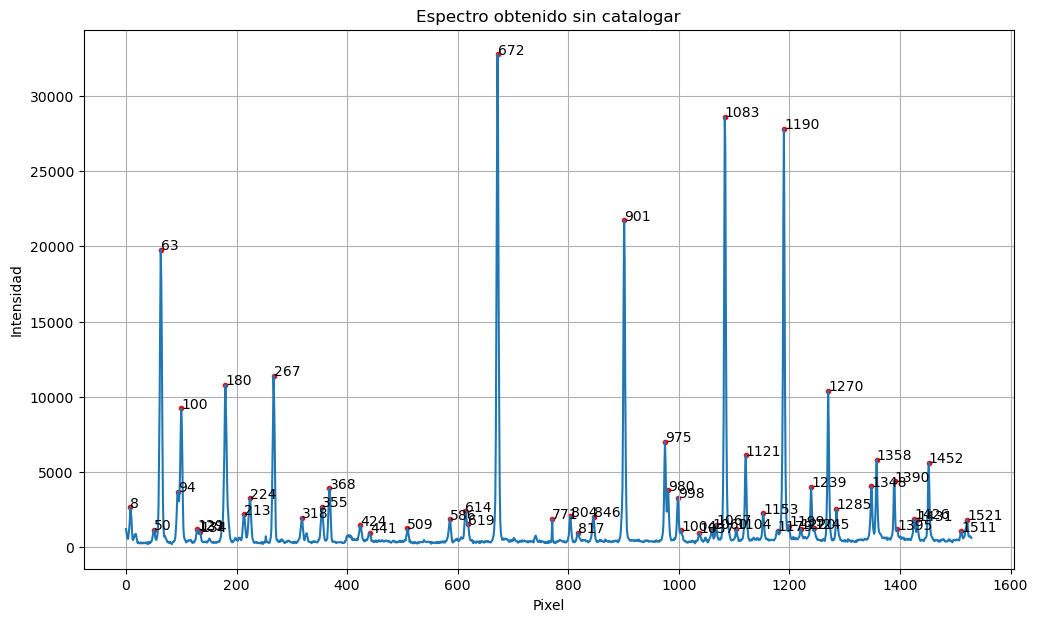

In [7]:
pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6480\th 6480 orden 2 spec.txt",950,18)

#Grafica
fig1_, ax1_ = plt.subplots(1,1, figsize=(12,7))
ax1_.plot(pixel_,intensidad_)
ax1_.scatter(marker_x_,marker_y_,marker='.',color = 'red')
ax1_.set_title('Espectro obtenido sin catalogar')
ax1_.set_xlabel('Pixel')
ax1_.set_ylabel('Intensidad')
ax1_.grid()
for i, label in enumerate(anotaciones_):
    plt.annotate(label, (marker_x_[i] + 0.1, marker_y_[i]))
#fig1_.savefig('th 6200 orden 2 espectro tratado.jpg')

[441, 509, 817, 1037, 1104, 1220]

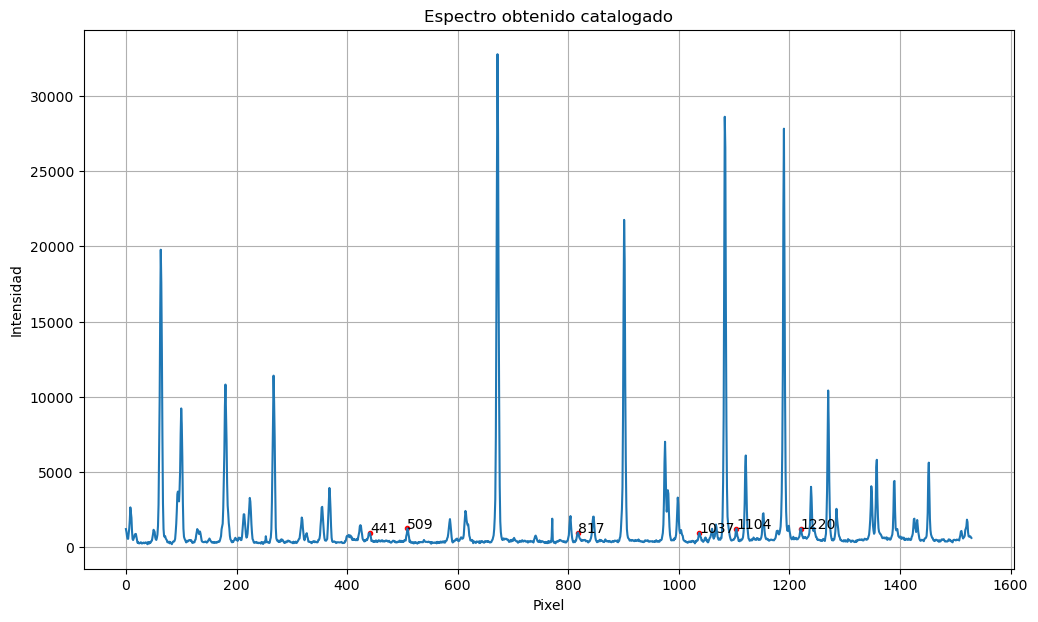

In [8]:
#Lista de pixeles que se descartan al no estar en el espectro
Pixnon_2 = [8, 50, 63, 100, 129,131, 134, 180, 213, 224, 267, 318, 355, 368, 424, 586, 614, 619, 672, 771, 901, 975, 998, 1004, 1060, 1067, 1083, 1121,  1179, 1190,1199, 1239, 1245, 1285, 1348, 1358, 1390,1395, 1452, 1511, 1521]

#Se obtiene el espectro limpio sin los píxeles diferentes
marker_xl_,marker_yl_, index_xl_,index_yl_,anotacionesl_ = DataCatalogue(Pixnon_2 + Pixnon_1,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)
    
#Grafica del espectro sin las líneas que no pertenecen  
fig2, ax2 = plt.subplots(1,1, figsize=(12,7))
ax2.plot(pixel,intensidad)
ax2.scatter(marker_xl_,marker_yl_,marker='.',color = 'red')
ax2.set_title('Espectro obtenido catalogado')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensidad')
ax2.grid()
for i, label in enumerate(anotacionesl_):
    plt.annotate(label, (marker_xl_[i] + 0.1, marker_yl_[i]))

marker_xl_

In [9]:
# #Longitudes de onda observadas en el catalogo de los píxeles que sí se lograron ver, ingreso manual
# catalog_long_2 = [  ]

#Lista de líneas sospechosas que sí están en el espectro pero no catalogadas
Pixesp_2 = [1037]

#Lista de líneas completamente sospechosas 
Pixsus_2 = [441, 509, 817,1104,1220]

#Unir dataframes de líneas en el catalogo
# DataFit_2 = MakeDataFrame(len(marker_xl),catalog_long_2,index_xl, index_yl)
# DataFit_2

#### Lineas para analizar individualmente

In [10]:
# #NO CONFUNDIR, son lineas ya analizadas, es para poder hacer un análisis más detallado a las lineas que por la intensidad toca separarlas del análisis general
# pixsus = [] 

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,10)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)

# catalog_long_2 = []
# DataFit_21 = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# DataFit_21

#### Lineas especiales

In [11]:
# # Solo descomentar si es necesario un análisis con gráfica para ver el ajuste
# pixsus = [] #lineas ya analizadas

# pixel_,intensidad_,marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt",275,18)
# marker_x_,marker_y_, index_x_,index_y_,anotaciones_ = DataCatalogue(pixsus,marker_x_,marker_y_, index_x_,index_y_,anotaciones_)


# def MakeDataFrame(rango,catalog_long,index_x_,index_y_):

#     Datafit = pd.DataFrame()
#     lineasfit = []
#     alturafit = []

#     for i in range(0,rango):
#         linea,altura, fity, fitx, x, y = AjusteLorentz(i,index_x_,index_y_)
#         lineasfit.append(linea)
#         alturafit.append(altura)
    

#     Datafit['Pixel'] = lineasfit
#     Datafit['Intensidad'] = alturafit
#     Datafit['Catalogo longitud'] = catalog_long

#     return Datafit, fity, fitx, x, y

# catalog_long_2 = []
# DataFit_2, fity, fitx, x, y = MakeDataFrame(len(marker_x_),catalog_long_2,index_x_,index_y_)

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(x,y)

### Unir todo en un dataframe

In [12]:
DataFit = DataFit_1
DataFit

,Pixel,Intensidad,Catalogo longitud
0,8.340459,2531.915059,6441.950
1,99.861025,8918.631036,6443.890
2,224.187629,3280.945769,6446.771
3,368.192870,4025.838344,6450.006
4,672.101623,34053.864569,6457.282
5,901.182300,23004.694468,6462.595


### Gráfica del espectro con las líneas encontradas 

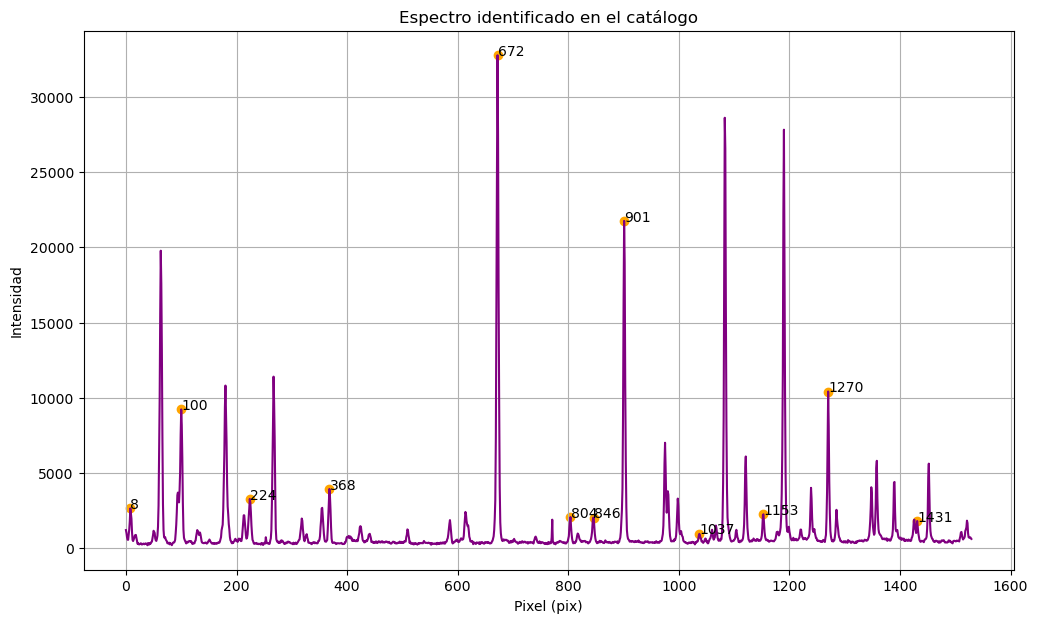

In [13]:
#Solo utilizar al final cuando ya se esté segura del análisis
Pixnon = list(set([441, 509, 817,1104,1220, 180, 213, 267, 318, 355, 586, 614, 771, 975, 998, 1083, 1121,  1190, 1239, 1285, 1348, 1358, 1390, 1452, 1521]+ [50, 63, 94, 129,131, 134, 180, 213, 267, 318, 355, 424, 586, 614, 619, 771, 975, 980, 998, 1004, 1060, 1067, 1083, 1121,  1179, 1190,1199, 1239, 1245, 1285, 1348, 1358, 1390,1395, 1426,1452, 1511, 1521]))

pixel,intensidad,marker_x,marker_y, index_x,index_y,anotaciones = DataProcess(r"C:\Users\clauw\Documents\Programming\Torium-Operation\Data\Th 6480\th 6480 orden 2 spec.txt",950,18)
markerx,markery, indexx,indexy,anotaciones = DataCatalogue(Pixnon ,marker_x,marker_y, index_x,index_y,anotaciones)

#Grafica con aquellas encontradas
fig, ax = plt.subplots(1,1, figsize=(12,7))
ax.plot(pixel,intensidad, color='purple')
ax.scatter(markerx,markery,color = 'orange')
ax.set_title('Espectro identificado en el catálogo')
ax.set_xlabel('Pixel (pix)')
ax.set_ylabel('Intensidad')
ax.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (markerx[i] + 0.1, markery[i]))

#fig.savefig('th 6480 espectro tratado.pdf')

### Regresión lineal de todos los puntos

[9.49479215e-07 2.23814715e-02 6.44170259e+03]


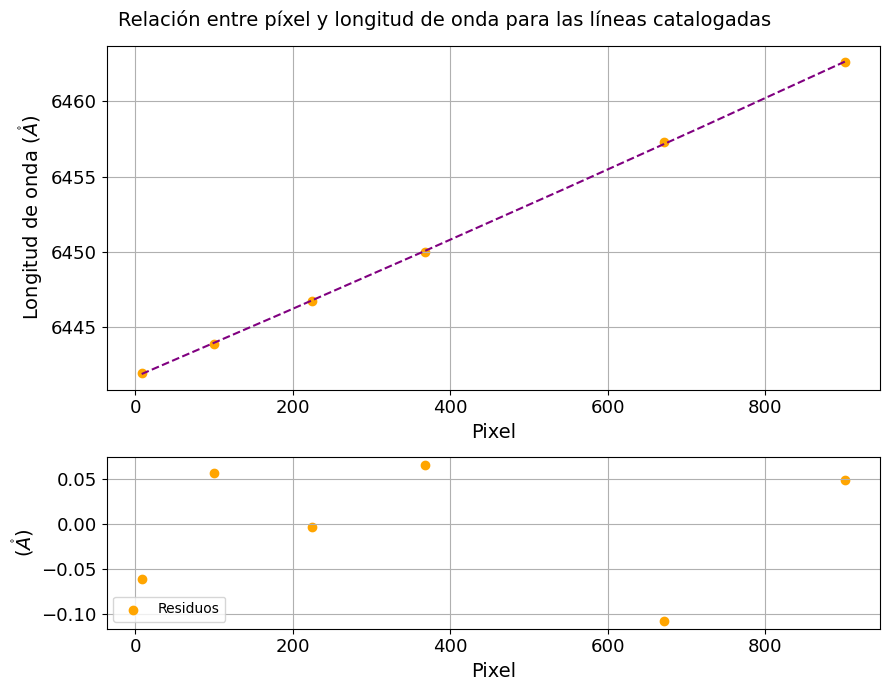

In [20]:
ym,_x,res,xres,param = LinearFit(DataFit['Pixel'],DataFit['Catalogo longitud'], 2) 

#Gráfico con residuos
fig3, axis3 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis3[0]
ax2 = axis3[1]

fig3.suptitle(r'Relación entre píxel y longitud de onda para las líneas catalogadas',fontsize=14)

ax1.scatter(DataFit['Pixel'],DataFit['Catalogo longitud'], color='orange')
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"Longitud de onda $(\mathring{A})$",fontsize=14)
ax1.set_xlabel(r'Pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.scatter(xres,res,label = 'Residuos',color='orange')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)
ax2.legend()
ax2.set_xlabel(r'Pixel',fontsize=14)
ax2.set_ylabel(r'$(\mathring{A})$',fontsize=14)

fig3.tight_layout()
#fig3.savefig('th 6480 regresion lineal.pdf')
print(param)

### Análisis líneas sospechosas

In [21]:
#Ver y tener los diferentes valores encontrados en el catalogo de nist
LineasSos_1 = LineasSus(Pixsus_1,param)
LineasSos_2 = LineasSus(Pixsus_2 ,param)

LineasSos = pd.concat([LineasSos_1,LineasSos_2], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)

LineasSos['Catalogo longitud orden 1'] = [None, None, None, 12895.165, 12898.8585, 12900.2443, 12901.9198, None, 12910.0904, 12911.943, 12919.2907, 12921.0246, None, None, None, 12933.5507, 12934.069, 12936.8356, 12937.0117, 12937.9838, 12938.9426, None, 12940.66341, 12940.9632, None, None]
LineasSos['Elemento orden 1'] = [None, None,None,'Cr I', 'Th I', 'Th I', 'Th II', None, 'Cr I', 'Th I', 'Th I', 'Th I', None, None, None, 'Th II', 'V I', 'Th I', 'Th I', 'Th I', 'Th I', None, 'Th II', 'Th I', None, None]
LineasSos['Residuos orden 1'] = LineasSos['Calibracion orden 1']- LineasSos['Catalogo longitud orden 1']
LineasSos['Catalogo longitud orden 3'] = [4295.58490, 4297.30655, 4297.6, 4298.5643, 4299.435, 4299.83922, 4301.2858, 4302.2209, 4303.3867, 4303.98919, 4306.36672, 4307.17608, 4309.5571, 4309.88681, 4310.9586, 4311.1342, 4311.3217, 4312.156, None, None, 4312.99799, 4313.4129, 4313.5133, 4313.7784, 4313.8642, 4314.0110]
LineasSos['Elemento orden 3'] = ['Th I', 'Th I', 'Ar VIII', 'Th I', 'Th II', 'Th I', 'Th II','Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th II', None, None, 'Th I', 'Th I', 'Th II', 'Th I', 'Th II', 'Th II']
LineasSos['Residuos orden 3'] = LineasSos['Calibracion orden 3']- LineasSos['Catalogo longitud orden 3']

LineasSos


,Pixel,Calibracion orden 1,Calibracion orden 2,Calibracion orden 3,Catalogo longitud orden 1,Elemento orden 1,Residuos orden 1,Catalogo longitud orden 3,Elemento orden 3,Residuos orden 3
0,63,12886.232790,6443.116395,4295.410930,NaN,None,NaN,4295.58490,Th I,-0.173970
1,180,12891.524044,6445.762022,4297.174681,NaN,None,NaN,4297.30655,Th I,-0.131869
2,213,12893.025848,6446.512924,4297.675283,NaN,None,NaN,4297.60000,Ar VIII,0.075283
3,267,12895.492268,6447.746134,4298.497423,12895.16500,Cr I,0.327268,4298.56430,Th I,-0.066877
4,318,12897.831834,6448.915917,4299.277278,12898.85850,Th I,-1.026666,4299.43500,Th II,-0.157722
5,355,12899.535349,6449.767674,4299.845116,12900.24430,Th I,-0.708951,4299.83922,Th I,0.005896
6,441,12903.514957,6451.757478,4301.171652,12901.91980,Th II,1.595157,4301.28580,Th II,-0.114148
7,509,12906.681510,6453.340755,4302.227170,NaN,None,NaN,4302.22090,Th I,0.006270
8,586,12910.288367,6455.144184,4303.429456,12910.09040,Cr I,0.197967,4303.38670,Th I,0.042756
9,614,12911.605534,6455.802767,4303.868511,12911.94300,Th I,-0.337466,4303.98919,Th I,-0.120679


In [22]:
# Por si se necesita quitar algun elemento None del dataframe .drop([2],axis=0).reset_index(drop=True)
LineasSos['Longitud catálogo'] = [4295.58490, 4297.30655, 4297.6, 4298.5643, 4299.435, 4299.83922, 4301.2858, 4302.2209, 4303.3867, 4303.98919, 4306.36672, 4307.17608, 4309.5571, 4309.88681, 4310.9586, 4311.1342, 4311.3217, 4312.156, None, 12938.94260, 12939.036708,4313.4129, 4313.5133, 4313.7784, 4313.8642, 4314.0110]
LineasSos['Longitud Calculada'] = [4295.417433, 4297.145972, 4297.641625, 4298.460912, 4299.244005, 4299.817582, 4301.166622,4302.245866,4303.475675,4303.923486,4306.413214,4307.126598,4309.46077,4309.779793,4310.896260,4311.154781,4311.358413,4312.127768 ,None, 12937.98380,12939.036708,4313.465992,4313.527064,4313.700869,4313.937312,4314.028436]
LineasSos['Elemento'] = ['Th I', 'Th I', 'Ar VIII', 'Th I', 'Th II', 'Th I', 'Th II','Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th I', 'Th II', None, 'Th I','Th I','Th I', 'Th II', 'Th I', 'Th II', 'Th II']

LineasSos = LineasSos.drop(['Catalogo longitud orden 1','Catalogo longitud orden 3', 'Calibracion orden 1', 'Calibracion orden 3','Elemento orden 1','Elemento orden 3','Residuos orden 3','Residuos orden 1', 'Calibracion orden 2'], axis=1)
LineasSos = LineasSos.drop([18],axis=0).reset_index(drop=True).drop([18],axis=0).reset_index(drop=True)
LineasSos
#Código para imprimir la tabla de latex
print(LineasSos.to_latex(index=False))

\begin{tabular}{rrrl}
\toprule
Pixel & Longitud catálogo & Longitud Calculada & Elemento \\
\midrule
63 & 4295.584900 & 4295.417433 & Th I \\
180 & 4297.306550 & 4297.145972 & Th I \\
213 & 4297.600000 & 4297.641625 & Ar VIII \\
267 & 4298.564300 & 4298.460912 & Th I \\
318 & 4299.435000 & 4299.244005 & Th II \\
355 & 4299.839220 & 4299.817582 & Th I \\
441 & 4301.285800 & 4301.166622 & Th II \\
509 & 4302.220900 & 4302.245866 & Th I \\
586 & 4303.386700 & 4303.475675 & Th I \\
614 & 4303.989190 & 4303.923486 & Th I \\
771 & 4306.366720 & 4306.413214 & Th I \\
817 & 4307.176080 & 4307.126598 & Th I \\
975 & 4309.557100 & 4309.460770 & Th I \\
998 & 4309.886810 & 4309.779793 & Th I \\
1083 & 4310.958600 & 4310.896260 & Th I \\
1104 & 4311.134200 & 4311.154781 & Th I \\
1121 & 4311.321700 & 4311.358413 & Th I \\
1190 & 4312.156000 & 4312.127768 & Th II \\
1285 & 12939.036708 & 12939.036708 & Th I \\
1348 & 4313.412900 & 4313.465992 & Th I \\
1358 & 4313.513300 & 4313.527064 & Th II \\
13

In [23]:
#Lineas que aparecen en el espectro y no son sospechosas
LineasSos_1_ = LineasSus(Pixesp_1,param)
LineasSos_2_ = LineasSus(Pixesp_2,param)
LineasSos_ = pd.concat([LineasSos_1_,LineasSos_2_], axis=0).sort_values(by='Pixel', ascending=True, na_position='first').reset_index(drop=True)
LineasSos_['Longitud Calculada'] = LineasSos_['Calibracion orden 2'] 
LineasSos_ = LineasSos_.drop(['Calibracion orden 2', 'Calibracion orden 1', 'Calibracion orden 3'],axis=1)

LineasSos_

#Código para imprimir la tabla de latex
print(LineasSos_.to_latex(index=False))

\begin{tabular}{rr}
\toprule
Pixel & Longitud Calculada \\
\midrule
804 & 6460.311056 \\
846 & 6461.316876 \\
1037 & 6465.933220 \\
1153 & 6468.770677 \\
1270 & 6471.658478 \\
1431 & 6475.674786 \\
\bottomrule
\end{tabular}



### Revisar residuos de lineas sospechosas

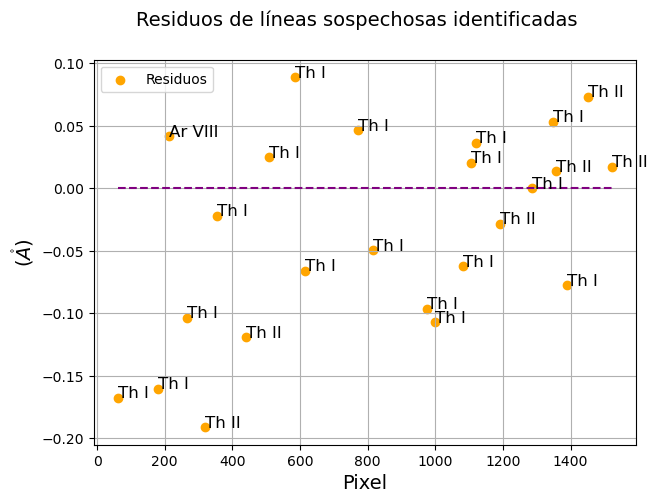

In [24]:
#Calcular residuos de las líneas sospechosas
nist = LineasSos['Longitud catálogo']
calc = LineasSos['Longitud Calculada']
residuos = calc - nist

pixel = LineasSos['Pixel']

#Etiquetas de elementos
label = [each for each in LineasSos['Elemento']]

#Gráfico con residuos
figr, axr = plt.subplots(1,1, figsize=(7,5))

figr.suptitle(r'Residuos de líneas sospechosas identificadas',fontsize=14)

axr.scatter(pixel,residuos,label = 'Residuos',color='orange')
axr.plot(pixel,np.linspace(0,0,len(residuos)),'--',color='purple')
axr.grid()
axr.legend()
axr.set_xlabel(r'Pixel',fontsize=14)
axr.set_ylabel(r'$(\mathring{A})$',fontsize=14)

for j in range (0, len(label)):
    plt.annotate(label[j], (pixel[j], residuos[j]),fontsize=12)

#figr.savefig('th 6200 residuos.pdf')